<a href="https://colab.research.google.com/github/PedroFlorencioNeto/acquisition-of-clinics/blob/main/notebooks/20231113_ClinicasEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=147ISZNwW7pfykfUtl_5kln6Q2R5JEsGl)

---

<h3><center> <b>Análise Estratégica da Aquisição de Clientes: O Caso da Empresa Real S.A.</b>

Mentoria - Renata Biaggi</center></h3>

Este notebook apresenta um estudo sobre a aquisição de clientes da empresa Real, com o objetivo de ...

**Autor:** Pedro Florencio de Almeida Neto - Cientista de Dados

<i>pedroflorencio@alu.ufc.br</i>

---

**Objetivo:** Apresentar as principais métricas relacionadas à aquisição de clínicas, de forma a identificar gargalos e oportunidades para otimizar a entrada de clínicas na empresa Real.

<br>**Perguntas Norteadoras:**<br>

<b>P.N.1.</b> Qual o perfil das clínicas que cancelam a assinatura?
* Qual período médio?

**Dados Disponibilizados:**
* *clinics.csv*
* *subscriptions.csv*
* *activity.csv*

#### **1. Contextualização**

A Real constrói uma plataforma de trabalho (SaaS - Software as a Service) focada especificamente em clínicas odontológicas, onde os dentistas e proprietários de clínica encontram todos os serviços necessários para gerir suas operações. O software oferece uma agenda moderna, prontuário eletrônico e ficha de pacientes, além de acesso a gestão financeira entre outros. O fluxo de aquisição de novos clientes funciona assim:
- O usuário pode se cadastrar diretamente ou pedir para conversar com um especialista antes disso.
- Uma vez cadastrado, ele tem acesso a um período de teste do produto (trial) onde pode usar todas as funcionalidades antes de assinar.
- Terminado seu período de testes, ele só poderá usar o produto quando assinar. O foco deste case será entender o período de trial e como ele pode ser melhorado.

Uma das funcionalidades mais populares do produto é o Financiamento Real, onde a Real financia o tratamento de um paciente sem riscos para a clínica, e o paciente paga para a Real em até 36 vezes (basicamente funcionando como um empréstimo). Este produto também é conhecido internamente como Buy now, pay later (BNPL).

Desta forma, deve ser mencionada a existência do credenciamento. O processo de credenciamento é uma validação de identidade da clínica, que a Real faz antes de aprovar ela para o uso do financiamento. É um processo anti-fraude e que nos permite avaliar de maneira mais assertiva os riscos de realizar financiamentos para clientes dessa clínica.

> <b>Datasets</b>
<br>Os arquivos incluem as clínicas que se cadastraram nos meses de Agosto e Setembro de 2023, e suas interações até a data de extração (18/10/2023).

-  A tabela <b>clinics</b> contém informações sobre as clínicas cadastradas e alguns marcos temporais delas, como trial e credenciamento. Aqui vale citar que a Real possui algumas parcerias com grandes redes e franquias de clínicas odontológicas pelo Brasil (diferenciadas das outras por colunas como business_segmentation e is_chain_clinic . Essas clínicas usam apenas o Financiamento Real, e desta forma devem ser removidas de análises sobre conversão de assinaturas.

- A tabela <b>subscriptions</b> contém informações de assinaturas de clínicas. A assinatura é definida como o início de um esquema de pagamentos recorrentes, possuindo início, data de fim (caso tenha sido encerrada) e a recorrência de pagamentos. Se uma clínica começar uma assinatura, encerrar ela e depois voltar a ser assinante, ela terá múltiplas linhas de assinatura.

- A tabela <b>activity</b> registra todas as atividades realizadas pela clínica, contendo registros temporais de quando a clínica desempenhou uma determinada ação. Temos diversos tipos de atividades no produto, que por sua vez estão organizadas em níveis hierarquicos para facilitar nosso trabalho com elas. Esses níveis estão disponíveis na tabela ( module , analytics_domain , feature ). As atividades também são divididas entre atividades válidas ou não, por uma questão de conveniência: algumas métricas são calculadas apenas considerando atividades “válidas” e outras não. Esta extração contém apenas atividades realizadas em período de trial.

#### **2. Bibliotecas**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### **3. Aquisição dos Dados**

In [ ]:
df_activity = pd.read_csv('/content/activity.csv')
df_clinics = pd.read_csv('/content/clinics.csv')
df_subscriptions = pd.read_csv('/content/subscriptions.csv')

#### **4. Entendimento dos Dados**

In [ ]:
df_activity.head()

,CLINIC_ID,ACTIVITY_AT,ACTIVITY_TYPE,FEATURE,MODULE,ANALYTICS_DOMAIN,IS_TRANSACTION,IS_BNPL_ACTIVITY,IS_VALID_ACTIVITY,IS_DELETION_ACTIVITY,IS_MANAGEMENT_ACTIVITY,IS_FINANCE_ACTIVITY
0,9825,2023-08-24 18:46:47.733,patient_discarded,patient_management,patient,patient,False,False,True,True,True,False
1,9984,2023-08-24 19:41:43.497,patient_created,patient_management,patient,patient,False,False,False,False,True,False
2,9984,2023-08-24 19:41:44.037,time_slot_created,scheduling,schedule,scheduling,False,False,True,False,True,False
3,9984,2023-08-24 19:51:20.451,patient_created,patient_management,patient,patient,False,False,False,False,True,False
4,9984,2023-08-24 19:51:46.663,time_slot_created,scheduling,schedule,scheduling,False,False,True,False,True,False


In [ ]:
df_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13941 entries, 0 to 13940
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLINIC_ID               13941 non-null  int64 
 1   ACTIVITY_AT             13941 non-null  object
 2   ACTIVITY_TYPE           13941 non-null  object
 3   FEATURE                 13941 non-null  object
 4   MODULE                  13941 non-null  object
 5   ANALYTICS_DOMAIN        13941 non-null  object
 6   IS_TRANSACTION          13941 non-null  bool  
 7   IS_BNPL_ACTIVITY        13941 non-null  bool  
 8   IS_VALID_ACTIVITY       13941 non-null  bool  
 9   IS_DELETION_ACTIVITY    13941 non-null  bool  
 10  IS_MANAGEMENT_ACTIVITY  13941 non-null  bool  
 11  IS_FINANCE_ACTIVITY     13941 non-null  bool  
dtypes: bool(6), int64(1), object(5)
memory usage: 735.3+ KB


In [ ]:
df_clinics.head()

,CLINIC_ID,CLINIC_CREATED_AT,BUSINESS_SEGMENTATION,IS_CHAIN_CLINIC,FIRST_USER_HUBSPOT_SOURCE,INTEREST_REASONS,INTEREST_CATEGORY_SIGNUP,HAS_INTEREST_BNPL,HAS_INTEREST_BNPL_ONLY,HAS_INTEREST_SAAS,...,IS_PAID_MEDIUM,HAS_ASKED_FOR_ACCREDITATION,HAS_STARTED_ACCREDITATION_AND_NOT_FINISHED,IS_ACCREDITATION_APPROVED,IS_ACCREDITATION_REPROVED,CLINIC_ACCREDITATION_STATUS,REQUEST_FINISHED_AT,ACCREDITATION_REQUESTED_AT,ACCREDITATION_APPROVED_AT,ACCREDITATION_REJECTED_AT
0,8993,2023-08-01 06:25:16.121,Independente,False,Inbound,"[""bnpl"", ""finance_management"", ""patients_manag...",BNPL e SaaS,True,False,True,...,True,False,False,False,False,NaN,NaN,NaN,NaN,NaN
1,8994,2023-08-01 06:58:36.251,Independente,False,Inbound,"[""finance_management"", ""patients_management"", ...",BNPL e SaaS,True,False,True,...,True,False,False,False,False,NaN,NaN,NaN,NaN,NaN
2,8995,2023-08-01 06:59:23.156,Independente,False,Inbound,"[""bnpl""]",Apenas BNPL,True,True,False,...,True,False,False,False,False,NaN,NaN,NaN,NaN,NaN
3,8996,2023-08-01 08:03:38.557,Independente,False,Inbound,"[""calendar"", ""bnpl"", ""patients_management"", ""f...",BNPL e SaaS,True,False,True,...,True,False,False,False,False,NaN,NaN,NaN,NaN,NaN
4,8997,2023-08-01 08:34:33.894,Independente,False,Inbound,"[""patients_management""]",Apenas SaaS,False,False,True,...,True,False,False,False,False,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_clinics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219 entries, 0 to 2218
Data columns (total 33 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   CLINIC_ID                                   2219 non-null   int64 
 1   CLINIC_CREATED_AT                           2219 non-null   object
 2   BUSINESS_SEGMENTATION                       2219 non-null   object
 3   IS_CHAIN_CLINIC                             2219 non-null   bool  
 4   FIRST_USER_HUBSPOT_SOURCE                   2219 non-null   object
 5   INTEREST_REASONS                            2066 non-null   object
 6   INTEREST_CATEGORY_SIGNUP                    2219 non-null   object
 7   HAS_INTEREST_BNPL                           2219 non-null   bool  
 8   HAS_INTEREST_BNPL_ONLY                      2219 non-null   bool  
 9   HAS_INTEREST_SAAS                           2219 non-null   bool  
 10  TRIAL_DURATION          

In [ ]:
df_subscriptions.head()

,CLINIC_ID,STRIPE_SUBSCRIPTION_ID,SUBSCRIPTION_START_DATE,SUBSCRIPTION_END_DATE,SUBSCRIPTION_CURRENT_PERIOD_STARTED_AT,SUBSCRIPTION_CURRENT_PERIOD_ENDS_AT,MOST_RECENT_INVOICE_CREATED_AT,LAST_PAYMENT_AT,CHECKOUT_STATUS,SUBSCRIPTION_STATUS,BILLING_INTERVAL_IN_MONTHS,FIRST_PAYMENT_METHOD_TYPE,FIRST_CARD_BRAND,FIRST_PAYMENT_AMOUNT,FIRST_PAYMENT_AMOUNT_OFF,FIRST_PAYMENT_PROMOTION_CODE,FIRST_PAYMENT_COUPON_ID,FIRST_PAYMENT_AMOUNT_OFF_2
0,9000,sub_1NaOxzCpjOdJI4gTfqZ2epGB,2023-08-01,2023-10-01,2023-09-01 17:14:51.000,2023-10-01 17:14:51.000,2023-09-01 17:16:49.000,2023-09-01 18:17:14.000,complete,canceled,1.0,Cartão de Crédito,mastercard,89.9,NaN,NaN,NaN,NaN
1,9032,sub_1Namy7CpjOdJI4gTzrxPLlFg,2023-08-02,NaN,2023-10-02 18:52:35.000,2023-11-02 18:52:35.000,2023-10-02 18:53:31.000,2023-08-09 10:20:45.000,complete,past_due,1.0,Cartão de Crédito,visa,89.9,NaN,NaN,NaN,NaN
2,9105,sub_1NalRdCpjOdJI4gTFRPqMhcv,2023-08-02,NaN,2023-10-02 17:14:57.000,2023-11-02 17:14:57.000,2023-10-02 17:16:56.000,2023-10-02 18:22:04.000,complete,active,1.0,Cartão de Crédito,visa,89.9,NaN,NaN,NaN,NaN
3,9027,sub_1Nb3CECpjOdJI4gTFLOepcZD,2023-08-03,2023-09-03,2023-08-03 12:12:14.000,2023-09-03 12:12:14.000,2023-08-03 12:12:14.000,2023-08-03 12:12:16.000,complete,canceled,1.0,Cartão de Crédito,visa,89.9,NaN,NaN,NaN,NaN
4,9072,sub_1Nb7E2CpjOdJI4gTsIJIy9b1,2023-08-03,2023-09-03,2023-08-03 16:30:22.000,2023-09-03 16:30:22.000,2023-08-03 16:30:22.000,2023-08-03 16:30:24.000,complete,canceled,1.0,Cartão de Crédito,visa,89.9,NaN,NaN,NaN,NaN


In [ ]:
df_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   CLINIC_ID                               385 non-null    int64  
 1   STRIPE_SUBSCRIPTION_ID                  385 non-null    object 
 2   SUBSCRIPTION_START_DATE                 384 non-null    object 
 3   SUBSCRIPTION_END_DATE                   46 non-null     object 
 4   SUBSCRIPTION_CURRENT_PERIOD_STARTED_AT  385 non-null    object 
 5   SUBSCRIPTION_CURRENT_PERIOD_ENDS_AT     385 non-null    object 
 6   MOST_RECENT_INVOICE_CREATED_AT          385 non-null    object 
 7   LAST_PAYMENT_AT                         371 non-null    object 
 8   CHECKOUT_STATUS                         383 non-null    object 
 9   SUBSCRIPTION_STATUS                     383 non-null    object 
 10  BILLING_INTERVAL_IN_MONTHS              384 non-null    float6

In [ ]:
df_subscriptions.CLINIC_ID.value_counts()

10358    2
9017     2
9000     1
10293    1
10107    1
        ..
10241    1
10157    1
10138    1
9935     1
10979    1
Name: CLINIC_ID, Length: 383, dtype: int64

#### **5. Pré-Processamento dos Dados**

##### **5.1. Tratamento das inconsistências de dados**


In [ ]:
df_subscriptions[df_subscriptions['CLINIC_ID'].duplicated(keep=False)]

,CLINIC_ID,STRIPE_SUBSCRIPTION_ID,SUBSCRIPTION_START_DATE,SUBSCRIPTION_END_DATE,SUBSCRIPTION_CURRENT_PERIOD_STARTED_AT,SUBSCRIPTION_CURRENT_PERIOD_ENDS_AT,MOST_RECENT_INVOICE_CREATED_AT,LAST_PAYMENT_AT,CHECKOUT_STATUS,SUBSCRIPTION_STATUS,BILLING_INTERVAL_IN_MONTHS,FIRST_PAYMENT_METHOD_TYPE,FIRST_CARD_BRAND,FIRST_PAYMENT_AMOUNT,FIRST_PAYMENT_AMOUNT_OFF,FIRST_PAYMENT_PROMOTION_CODE,FIRST_PAYMENT_COUPON_ID,FIRST_PAYMENT_AMOUNT_OFF_2
14,9017,sub_1NdIwKCpjOdJI4gT18TfQpi3,2023-08-09,2023-10-15,2023-10-09 17:25:08.000,2023-11-09 17:25:08.000,2023-10-09 17:35:24.000,2023-09-09 18:32:33.000,complete,canceled,1.0,Cartão de Crédito,visa,89.9,NaN,NaN,NaN,NaN
196,10358,sub_1NqeJPCpjOdJI4gTddvsJNzn,2023-09-15,2023-10-18,2023-10-15 12:52:07.000,2023-11-15 12:52:07.000,2023-10-15 13:01:28.000,NaN,NaN,NaN,1.0,Cartão de Crédito,mastercard,89.9,NaN,NaN,NaN,NaN
379,10358,sub_1O2hEOCpjOdJI4gTeYuyijNI,2023-10-18,NaN,2023-10-18 18:24:44.000,2023-11-18 18:24:44.000,2023-10-18 18:24:44.000,2023-10-19 12:11:15.000,open,active,1.0,Boleto,NaN,89.9,NaN,NaN,NaN,NaN
382,9017,sub_1O2tjnCpjOdJI4gT1Ta31mBR,2023-10-19,NaN,2023-10-19 07:45:59.000,2023-11-19 07:45:59.000,2023-10-19 07:45:59.000,2023-10-19 07:55:08.000,complete,active,1.0,Cartão de Crédito,visa,89.9,NaN,NaN,NaN,NaN


As clínicas de ID 10350 e 9017 tiveram suas respectivas assinaturas canceladas, mas retornaram depois de 1 e 3 dias, respectivamente. A estratégia adotada foi a remoção das linhas que constam o cancelamento.

In [ ]:
# linhas a serem excluidas
rows = [14,196]

df_subscriptions.drop(index=rows, inplace=True)

#### **6. Análise Exploratória dos Dados (E.D.A)**

##### **6.1. Qual o percentual de clínicas que cancelaram no período estudado?**

In [ ]:
# contagem dos status das assinaturas
df_status = df_subscriptions['SUBSCRIPTION_STATUS'].value_counts().reset_index()

# adequando dataframe
df_status.rename(columns={'index':'situacao','SUBSCRIPTION_STATUS':'contagem'},
                 inplace=True)
df_status.replace(to_replace={'active':'Ativo',
                              'canceled':'Cancelado',
                              'past_due':'Atrasado',
                              'incomplete':'Incompleto'},
                  inplace=True)


# resultado do processamento
DEBUG = True
if DEBUG:
    print(df_status)

     situacao  contagem
0       Ativo       341
1   Cancelado        31
2    Atrasado         9
3  Incompleto         1


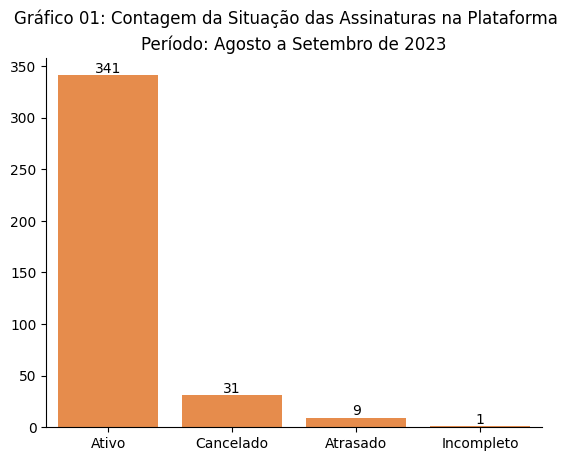

In [66]:
# --- grafico de barras da contagem da situacao das assinaturas

ax = sns.barplot(data=df_status,x='situacao',y='contagem', color='#FF8833')

# adicionando valores acima das barras
ax.bar_label(ax.containers[0], fontsize=10)

# removendo eixos desnecessarios
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

# adequando textos
plt.xlabel('')
plt.ylabel('')
plt.suptitle('Gráfico 01: Contagem da Situação das Assinaturas na Plataforma', fontsize=12)
plt.title('Período: Agosto a Setembro de 2023')
plt.show()

In [70]:
# exportando dados para producao da visualizacao
df_status.to_csv('situacao.csv', index=False, encoding='utf-8')

**Obrigado!** 🙂